# Algoritmo KNN

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from flask import Flask, jsonify, request
import requests
import json
import time
from threading import Thread
from sklearn.preprocessing import StandardScaler

In [57]:
dataframe = pd.read_csv('DSCancerDeMamaSinDatosPerdidos.csv', sep=';')
clasificadores = ['Benigno', 'Maligno']
dataframe.head(10)

,BIRADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,57,1,5,3,1
4,5,76,1,4,3,1
5,3,42,2,1,3,1
6,4,36,3,1,2,0
7,4,60,2,1,2,0
8,4,54,1,1,3,0
9,3,52,3,4,3,0


In [59]:
dataframe.describe()

,BIRADS,Age,Shape,Margin,Density,Severity
count,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000
mean,4.314634,55.739024,2.775610,2.808537,2.915854,0.481707
std,0.669248,14.684062,1.243647,1.569295,0.351508,0.499970
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.750000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,5.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [61]:
dataframe.groupby('Severity').size()

Severity
0    425
1    395
dtype: int64

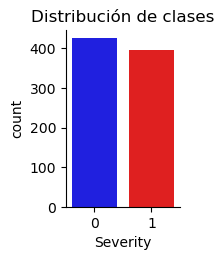

In [63]:
# Mostrar gráfico de barras
import seaborn as sb

#Aseguramos que los números son enteros
dataframe['Severity'] = dataframe['Severity'].astype(int)
sb.catplot(x='Severity', hue='Severity', data= dataframe, kind="count", height=2.5, aspect=0.8, palette={0:"blue",1:"red"}, legend=False)
plt.title("Distribución de clases")
plt.show()

In [65]:
x = dataframe.drop('Severity', axis=1)
y = dataframe['Severity']
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=30)

In [69]:
from sklearn.neighbors import KNeighborsClassifier
knn_mm = KNeighborsClassifier(n_neighbors=3)
knn_mm.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [71]:
predicciones = knn_mm.predict(X_test)

         Benigno  Maligno
Benigno      102       17
Maligno       32       95
              precision    recall  f1-score   support

     Benigno       0.76      0.86      0.81       119
     Maligno       0.85      0.75      0.79       127

    accuracy                           0.80       246
   macro avg       0.80      0.80      0.80       246
weighted avg       0.81      0.80      0.80       246



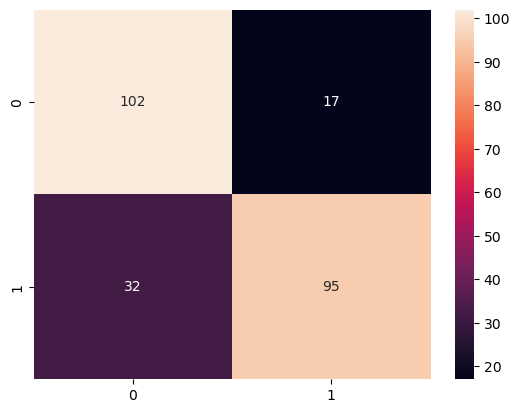

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test,predicciones).ravel()

sns.heatmap(confusion_matrix(y_test,predicciones), annot=True, fmt="d")
            
labels = ["Benigno","Maligno"]
matriz = confusion_matrix(y_test,predicciones, labels=[0,1])
print(pd.DataFrame(matriz, index = labels, columns = labels))

print(classification_report(y_test,predicciones,target_names=clasificadores))
#Columnas lo que dice el sistema, filas lo que dice la realidad

In [75]:
sample = pd.DataFrame([[4, 65, 3, 5, 3]], columns=x.columns)
print("\nEjemplo de predicción:")
print(f"Predicción: {clasificadores[knn_mm.predict(sample)[0]]}")
print(f"Probabilidades: {knn_mm.predict_proba(sample)}")


Ejemplo de predicción:
Predicción: Maligno
Probabilidades: [[0. 1.]]


C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [77]:
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_mm, f)

# Algoritmo SVM

In [80]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle

In [82]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}

In [84]:
svm = SVC(probability=True)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Mejores parámetros SVM:", grid_search.best_params_)
print("Mejor precisión en validación cruzada SVM:", grid_search.best_score_)

Mejores parámetros SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor precisión en validación cruzada SVM: 0.8344927536231884


In [85]:
best_model = grid_search.best_estimator_
predictions_svm = best_model.predict(X_test)
print("\nReporte de clasificación SVM:")
print(classification_report(y_test, predictions_svm))

scores = cross_val_score(best_model, x_scaled, np.ravel(y), cv=5)
print("Precisión promedio con validación cruzada SVM:", scores.mean())
print("Desviación estándar SVM:", scores.std())


Reporte de clasificación SVM:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       119
           1       0.93      0.78      0.85       127

    accuracy                           0.85       246
   macro avg       0.86      0.86      0.85       246
weighted avg       0.86      0.85      0.85       246

Precisión promedio con validación cruzada SVM: 0.8292682926829269
Desviación estándar SVM: 0.02962184829631979


In [86]:
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

sample_data = pd.DataFrame([[4, 65, 3, 5, 3]], columns=['BIRADS', 'Age', 'Shape', 'Margin', 'Density'])
sample_data_scaled = scaler.transform(sample_data)
print("Predicción para nuevos datos:", best_model.predict(sample_data_scaled))

Predicción para nuevos datos: [0]


In [87]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# API

In [93]:
from flask import Flask, jsonify, request
app = Flask(__name__)

try:
    with open('knn_model.pkl', 'rb') as f:
        knn_model = pickle.load(f)
    print("Modelo KNN cargado correctamente")
except Exception as e:
    print("Error al cargar el modelo KNN:", str(e))
    knn_model = None

try:
    with open('svm_model.pkl', 'rb') as f:
        svm_model = pickle.load(f)
    print("Modelo SVM cargado correctamente")
except Exception as e:
    print("Error al cargar el modelo SVM:", str(e))
    svm_model = None

try:
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("Scaler cargado correctamente")
except Exception as e:
    print("Error al cargar el scaler:", str(e))
    scaler = None

@app.route('/predict', methods=['POST'])
def predict():
    try:
        if knn_model is None or svm_model is None or scaler is None:
            print("Error: Uno o más componentes no están disponibles")
            return jsonify({'error': 'Models or scaler not loaded'}), 500
        
        req_json = request.get_json()
        print("Datos recibidos en la API:", req_json)
        input_data = pd.DataFrame(req_json)
        print("DataFrame creado:", input_data.to_dict())
    except Exception as e:
        print("Error al procesar JSON:", str(e))
        return jsonify({'error': str(e)}), 400

    if input_data.empty:
        print("Error: DataFrame vacío")
        return jsonify({'error': 'No data provided'}), 400

    expected_columns = ['BIRADS', 'Age', 'Shape', 'Margin', 'Density']
    if not all(col in input_data.columns for col in expected_columns):
        print("Error: Columnas faltantes", input_data.columns.tolist())
        return jsonify({'error': 'Missing required columns'}), 400

    input_data_scaled = scaler.transform(input_data[expected_columns])

    model_choice = request.args.get('model', 'knn').lower()
    print(f"Modelo seleccionado: {model_choice}")
    
    if model_choice == 'svm':
        loaded_model = svm_model
        print("Usando modelo SVM")
    else:
        loaded_model = knn_model
        print("Usando modelo KNN")
    
    try:
        predictions = loaded_model.predict(input_data_scaled)
        predictions = [clasificadores[pred] for pred in predictions]
        probabilities = loaded_model.predict_proba(input_data_scaled).tolist()
        print("Predicciones realizadas:", predictions)
    except Exception as e:
        print("Error al hacer predicciones:", str(e))
        return jsonify({'error': 'Prediction failed'}), 500

    response = jsonify({
        'model_used': model_choice,
        'predictions': predictions,
        'probabilities': probabilities
    })
    response.status_code = 200
    print("Respuesta enviada:", response.get_json())
    return response

def run_flask():
    app.run(port=8001, use_reloader=False)

if __name__ == '__main__':
    Thread(target=run_flask).start()
    time.sleep(3)

Modelo KNN cargado correctamente
Modelo SVM cargado correctamente
Scaler cargado correctamente
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8001
Press CTRL+C to quit


In [97]:
test_data = pd.DataFrame({
    'BIRADS': [4, 5],
    'Age': [65, 70],
    'Shape': [3, 4],
    'Margin': [5, 5],
    'Density': [3, 3]
})

data_json = test_data.to_json(orient='records')

print("Datos enviados en el POST:")
print(data_json)

headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}

try:
    print("Enviando solicitud POST a http://localhost:8001/predict?model=knn")
    response = requests.post('http://localhost:8001/predict?model=knn', data=data_json, headers=headers)
    print('\nConsulta a la API:')
    print('Status:', response.status_code)
    print('Respuesta:', response.json())
except Exception as e:
    print(f"Error al consultar la API: {e}")

Datos enviados en el POST:
[{"BIRADS":4,"Age":65,"Shape":3,"Margin":5,"Density":3},{"BIRADS":5,"Age":70,"Shape":4,"Margin":5,"Density":3}]
Enviando solicitud POST a http://localhost:8001/predict?model=knn


127.0.0.1 - - [05/May/2025 18:48:22] "POST /predict?model=knn HTTP/1.1" 200 -


Datos recibidos en la API: [{'BIRADS': 4, 'Age': 65, 'Shape': 3, 'Margin': 5, 'Density': 3}, {'BIRADS': 5, 'Age': 70, 'Shape': 4, 'Margin': 5, 'Density': 3}]
DataFrame creado: {'BIRADS': {0: 4, 1: 5}, 'Age': {0: 65, 1: 70}, 'Shape': {0: 3, 1: 4}, 'Margin': {0: 5, 1: 5}, 'Density': {0: 3, 1: 3}}
Modelo seleccionado: knn
Usando modelo KNN
Predicciones realizadas: ['Benigno', 'Maligno']
Respuesta enviada: {'model_used': 'knn', 'predictions': ['Benigno', 'Maligno'], 'probabilities': [[0.6666666666666666, 0.3333333333333333], [0.3333333333333333, 0.6666666666666666]]}

Consulta a la API:
Status: 200
Respuesta: {'model_used': 'knn', 'predictions': ['Benigno', 'Maligno'], 'probabilities': [[0.6666666666666666, 0.3333333333333333], [0.3333333333333333, 0.6666666666666666]]}
